In [1]:
!pip install keras-tuner --upgrade



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import os
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/NSFW3_project.zip

Streaming output truncated to the last 5000 lines.
 extracting: NSFW3_project/test/not safe/f59cbcef-0bdd-4878-9cb2-09a0bbde9c7b.jpg  
 extracting: NSFW3_project/test/not safe/f5a3b83e-31dc-4756-a0b2-e0a863702b3f.jpg  
  inflating: NSFW3_project/test/not safe/f5bb4b2d-7561-4675-93cb-1d88b6679b4f.jpg  
  inflating: NSFW3_project/test/not safe/f5c0c797-babf-4646-8882-f8867b0097a7.jpg  
 extracting: NSFW3_project/test/not safe/f628bd7a-8d9a-42c4-b43a-f909a5573819.jpg  
  inflating: NSFW3_project/test/not safe/f63a20d2-af2b-4260-ba94-a5fc6c0d0926.jpg  
  inflating: NSFW3_project/test/not safe/f6807535-a530-454a-ae97-4e3c06c762ed.jpg  
  inflating: NSFW3_project/test/not safe/f69a410b-9824-42bb-8b78-62b74ec46676.jpg  
  inflating: NSFW3_project/test/not safe/f6bda219-ede7-44ab-a9a8-e9a23fee8934.jpg  
  inflating: NSFW3_project/test/not safe/f6de7ab5-c895-46ee-8321-1b6306abd814.jpg  
  inflating: NSFW3_project/test/not safe/f6dee877-512b-4904-915b-7bb5e224e7d6.jpg  
  inflating: NSFW3_projec

In [5]:
# data flow parameters
training_data_dir = '/content/NSFW3_project/train'
validation_data_dir = '/content/NSFW3_project/valid'
batch_size= 32
image_width =224
image_height =244
num_channels = 3
num_classes =2

In [6]:
# image generators
training_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                       rotation_range =20,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       zoom_range =0.2,
                                       horizontal_flip =True,
                                       brightness_range = (0.5, 1.5),
                                       fill_mode = 'nearest')

validation_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [7]:
# image flows
training_set = training_generator.flow_from_directory(directory = training_data_dir,
                                                     target_size = (image_width, image_height),
                                                     batch_size = batch_size,
                                                     class_mode = 'binary')
validation_set = validation_generator.flow_from_directory(directory = validation_data_dir,
                                                     target_size = (image_width, image_height),
                                                     batch_size = batch_size,
                                                     class_mode = 'binary')

Found 3432 images belonging to 2 classes.
Found 805 images belonging to 2 classes.


In [8]:
# network architecture
vgg = VGG16(input_shape = (image_width, image_height, num_channels), include_top = False)
vgg.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                              

In [9]:
def build_model(hp):
    # Load the pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, num_channels))

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers on top of the base model
    x = Flatten()(base_model.output)
    for i in range(hp.Int("n_Dense_Layers", min_value=1, max_value=4, step=1)):
        x = Dense(hp.Int(f"Dense_{i}_Neurons", min_value=32, max_value=256, step=32),
                  kernel_initializer=hp.Choice(f"kernel_init_{i}", values=['glorot_normal', 'he_normal']))(x)
        x = BatchNormalization()(x)
        x = Activation(hp.Choice('activation', values=['relu', 'LeakyReLU']))(x)
        if hp.Boolean("Dropout"):
            x = Dropout(0.5)(x)

    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
                  metrics=['accuracy'])

    return model


In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

tuner = RandomSearch(hypermodel = build_model,
                    objective = 'val_accuracy',
                    max_trials = 2,
                    executions_per_trial = 1,
                    directory = os.path.normpath(''),
                    project_name = 'NSFW3_Project_CNN',
                    overwrite = True)

tuner.search(x = training_set, 
            validation_data = validation_set,
            epochs = 50,
            batch_size = 32)

Trial 2 Complete [03h 49m 39s]
val_accuracy: 0.9465838670730591

Best val_accuracy So Far: 0.9465838670730591
Total elapsed time: 07h 43m 41s


In [13]:
tuner.results_summary()


Results summary
Results in ./NSFW3_Project_CNN
Showing 10 best trials
Trial summary
Hyperparameters:
n_Dense_Layers: 3
Dense_0_Neurons: 160
kernel_init_0: glorot_normal
activation: relu
Dropout: True
learning_rate: 0.001
Dense_1_Neurons: 32
kernel_init_1: glorot_normal
Dense_2_Neurons: 32
kernel_init_2: glorot_normal
Score: 0.9465838670730591
Trial summary
Hyperparameters:
n_Dense_Layers: 1
Dense_0_Neurons: 224
kernel_init_0: glorot_normal
activation: relu
Dropout: True
learning_rate: 0.1
Dense_1_Neurons: 64
kernel_init_1: glorot_normal
Dense_2_Neurons: 96
kernel_init_2: he_normal
Score: 0.9465838670730591


In [14]:
tuner.get_best_hyperparameters()[0].values

{'n_Dense_Layers': 3,
 'Dense_0_Neurons': 160,
 'kernel_init_0': 'glorot_normal',
 'activation': 'relu',
 'Dropout': True,
 'learning_rate': 0.001,
 'Dense_1_Neurons': 32,
 'kernel_init_1': 'glorot_normal',
 'Dense_2_Neurons': 32,
 'kernel_init_2': 'glorot_normal'}

In [15]:
tuner.get_best_models()[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 61, 128)       0     

In [17]:
import tensorflow as tf
# Define hyperparameters
n_dense_layers = 3
dense_neurons = [160, 32, 32]
kernel_initializer = ['glorot_normal', 'glorot_normal', 'glorot_normal']
activation = 'relu'
dropout = True
learning_rate = 0.001

# Load VGG16 model with pretrained weights
vgg16 = VGG16(weights='imagenet', include_top=False,input_shape=(image_width, image_height, num_channels))
vgg16.trainable = False

# Define the model architecture
model = tf.keras.Sequential()

# Add the frozen VGG16 model as the base
model.add(vgg16)

# Add the flattening layer
model.add(tf.keras.layers.Flatten())

# Add the hidden layers
for i in range(n_dense_layers):
    model.add(tf.keras.layers.Dense(dense_neurons[i], kernel_initializer=kernel_initializer[i]))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation))
    if dropout:
        model.add(tf.keras.layers.Dropout(0.5))

# Add the output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 160)               4014240   
                                                                 
 batch_normalization_3 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 160)               0         
                                                                 
 dropout_3 (Dropout)         (None, 160)               0         
                                                        

In [19]:
# training parameters
num_epochs = 50
model_filename = 'NSFW.h1'

In [20]:
# callbacks
save_best_model = ModelCheckpoint(filepath = model_filename,
                                 monitor = 'val_accuracy',
                                 mode = 'max',
                                 verbose =1,
                                 save_best_only = True)

In [22]:
# train the network
history = model.fit(x = training_set,
                   validation_data = validation_set,
                   batch_size = batch_size,
                   epochs = num_epochs,
                   callbacks = [save_best_model])

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 0.2410 - accuracy: 0.9143
Epoch 1: val_accuracy improved from 0.92298 to 0.92671, saving model to NSFW.h1


108/108 [==============================] - 291s 3s/step - loss: 0.2410 - accuracy: 0.9143 - val_loss: 0.1762 - val_accuracy: 0.9267
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9257
Epoch 2: val_accuracy improved from 0.92671 to 0.93292, saving model to NSFW.h1


108/108 [==============================] - 286s 3s/step - loss: 0.2064 - accuracy: 0.9257 - val_loss: 0.1557 - val_accuracy: 0.9329
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9324
Epoch 3: val_accuracy did not improve from 0.93292
108/108 [==============================] - 274s 3s/step - loss: 0.1893 - accuracy: 0.9324 - val_loss: 0.1584 - val_accuracy: 0.9329
Epoch 4/50
108/108 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9292
Epoch 4: val_accuracy did not improve from 0.93292
108/108 [==============================] - 273s 3s/step - loss: 0.1877 - accuracy: 0.9292 - val_loss: 0.1572 - val_accuracy: 0.9329
Epoch 5/50
108/108 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9385
Epoch 5: val_accuracy did not improve from 0.93292
108/108 [==============================] - 275s 3s/step - loss: 0.1594 - accuracy: 0.9385 - val_loss: 0.1542 - val_accuracy: 0.9304
Epoch 6/50
108/108 [===========

108/108 [==============================] - 277s 3s/step - loss: 0.1659 - accuracy: 0.9356 - val_loss: 0.1599 - val_accuracy: 0.9366
Epoch 7/50
108/108 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9435
Epoch 7: val_accuracy did not improve from 0.93665
108/108 [==============================] - 276s 3s/step - loss: 0.1551 - accuracy: 0.9435 - val_loss: 0.1450 - val_accuracy: 0.9366
Epoch 8/50
108/108 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9429
Epoch 8: val_accuracy improved from 0.93665 to 0.93913, saving model to NSFW.h1


108/108 [==============================] - 279s 3s/step - loss: 0.1490 - accuracy: 0.9429 - val_loss: 0.1568 - val_accuracy: 0.9391
Epoch 9/50
108/108 [==============================] - ETA: 0s - loss: 0.1453 - accuracy: 0.9464
Epoch 9: val_accuracy improved from 0.93913 to 0.94037, saving model to NSFW.h1


108/108 [==============================] - 287s 3s/step - loss: 0.1453 - accuracy: 0.9464 - val_loss: 0.1457 - val_accuracy: 0.9404
Epoch 10/50
108/108 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9429
Epoch 10: val_accuracy did not improve from 0.94037
108/108 [==============================] - 282s 3s/step - loss: 0.1457 - accuracy: 0.9429 - val_loss: 0.1640 - val_accuracy: 0.9304
Epoch 11/50
108/108 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9513
Epoch 11: val_accuracy did not improve from 0.94037
108/108 [==============================] - 278s 3s/step - loss: 0.1359 - accuracy: 0.9513 - val_loss: 0.1550 - val_accuracy: 0.9379
Epoch 12/50
108/108 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9470
Epoch 12: val_accuracy did not improve from 0.94037
108/108 [==============================] - 277s 3s/step - loss: 0.1378 - accuracy: 0.9470 - val_loss: 0.1639 - val_accuracy: 0.9354
Epoch 13/50
108/108 [====

108/108 [==============================] - 282s 3s/step - loss: 0.1287 - accuracy: 0.9531 - val_loss: 0.1643 - val_accuracy: 0.9429
Epoch 16/50
108/108 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9557
Epoch 16: val_accuracy improved from 0.94286 to 0.94534, saving model to NSFW.h1


108/108 [==============================] - 285s 3s/step - loss: 0.1275 - accuracy: 0.9557 - val_loss: 0.1606 - val_accuracy: 0.9453
Epoch 17/50
108/108 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.9601
Epoch 17: val_accuracy did not improve from 0.94534
108/108 [==============================] - 278s 3s/step - loss: 0.1157 - accuracy: 0.9601 - val_loss: 0.1520 - val_accuracy: 0.9391
Epoch 18/50
108/108 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9580
Epoch 18: val_accuracy did not improve from 0.94534
108/108 [==============================] - 279s 3s/step - loss: 0.1181 - accuracy: 0.9580 - val_loss: 0.1883 - val_accuracy: 0.9379
Epoch 19/50
108/108 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.9531
Epoch 19: val_accuracy did not improve from 0.94534
108/108 [==============================] - 278s 3s/step - loss: 0.1163 - accuracy: 0.9531 - val_loss: 0.1871 - val_accuracy: 0.9416
Epoch 20/50
108/108 [====

108/108 [==============================] - 286s 3s/step - loss: 0.1091 - accuracy: 0.9607 - val_loss: 0.1743 - val_accuracy: 0.9478
Epoch 22/50
108/108 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9569
Epoch 22: val_accuracy did not improve from 0.94783
108/108 [==============================] - 278s 3s/step - loss: 0.1137 - accuracy: 0.9569 - val_loss: 0.1756 - val_accuracy: 0.9429
Epoch 23/50
108/108 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9604
Epoch 23: val_accuracy did not improve from 0.94783
108/108 [==============================] - 279s 3s/step - loss: 0.1058 - accuracy: 0.9604 - val_loss: 0.1836 - val_accuracy: 0.9441
Epoch 24/50
108/108 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9563
Epoch 24: val_accuracy did not improve from 0.94783
108/108 [==============================] - 271s 3s/step - loss: 0.1154 - accuracy: 0.9563 - val_loss: 0.1730 - val_accuracy: 0.9391
Epoch 25/50
108/108 [====

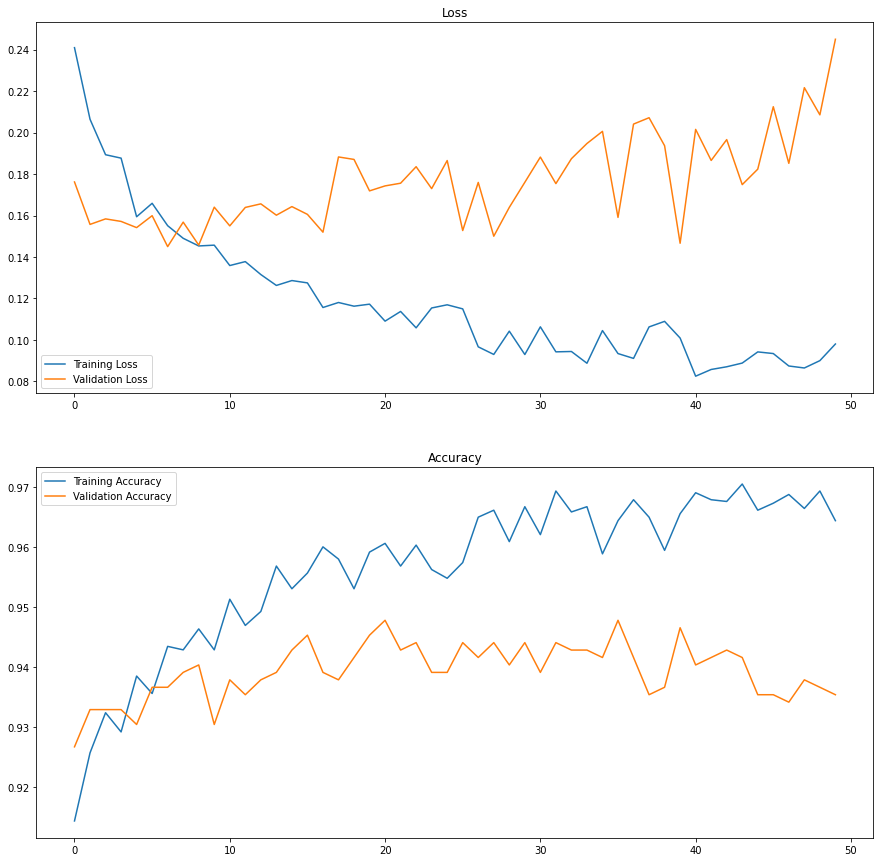

In [24]:
import matplotlib.pyplot as plt

# plot validation results
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Training Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["accuracy"], label="Training Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[0].legend()
ax[1].legend()
plt.show()

In [25]:
# get best epoch performance for validation accuracy
max(history.history['val_accuracy'])

0.947826087474823

In [23]:
#########################################################################
# Make Predictions On New Data (Test Set)
#########################################################################

In [26]:
# import required packages
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd
from os import listdir


In [46]:
# parameters for prediction
model_filename = 'NSFW.h1'
image_width =224
image_height =244
labels_list = ['not safe', 'safe']

In [47]:
model = load_model(model_filename)

In [69]:
# image pre-processing function

def preprocess_image(filepath):
    image =load_img(filepath,target_size = (image_width,image_height))

    image = img_to_array(image)
    image = np.expand_dims(image, axis =0)
    image = preprocess_input(image)
    
    return image

# image prediction function

def make_prediction(image):
    class_probs = model.predict(image)
    predicted_prob = class_probs[0][0]  # probability of positive class
    predicted_label = 'safe' if predicted_prob > 0.5 else 'not safe'
    
    return predicted_label, predicted_prob


In [70]:
# loop through test data

source_dir ='/content/NSFW3_project/test'
folder_names =  ['not safe', 'safe']
actual_labels = []
predicted_labels = []
predicted_probabilities = []
filenames =[]

for folder in folder_names:
    
    images = listdir(source_dir + '/' + folder)
    
    for image in images:
        
        processed_image = preprocess_image(source_dir + '/'+ folder + '/' + image)
        predicted_label, predicted_probability = make_prediction(processed_image)
        
        actual_labels.append(folder)
        predicted_labels.append(predicted_label)
        predicted_probabilities.append(predicted_probability)
        filenames.append(image)

1/1 [==============================] - 0s 22ms/step


In [71]:
# create dataframe to analyse
prediction_df = pd.DataFrame({"actual_label": actual_labels,
                             "predicted_label": predicted_labels,
                             "predicted_probability": predicted_probabilities,
                             "filename": filenames})

In [72]:
prediction_df['correct'] = np.where(prediction_df['actual_label']== prediction_df['predicted_label'], 1, 0)
prediction_df.sample(10)

,actual_label,predicted_label,predicted_probability,filename,correct
842,not safe,not safe,0.041086,dfce48df-329a-4e3c-a578-6cc56dc50622.jpg,1
1308,not safe,not safe,0.007607,02852247-5f3e-4507-9400-ac2f1f5fbe1f.jpg,1
228,not safe,not safe,0.000323,4f28ad17-8f33-43b2-952a-cbc62321f957.jpg,1
2165,safe,safe,0.999444,e4625154-a0db-4f49-9ce9-f0658b964303.jpg,1
701,not safe,not safe,0.000620,24031f23-aa88-4346-8b66-65dece56c64a.jpg,1
2321,safe,safe,0.998882,b34c669b-0681-4b1f-af55-498d43838509.jpg,1
321,not safe,not safe,0.014727,74104de1-ff3b-4be1-8f4c-5cc2e9433999.jpg,1
2257,safe,safe,0.999250,be889029-fdc9-42fd-8c75-8571a0fa0db1.jpg,1
9,not safe,not safe,0.315665,2d87c7fc-0dac-4745-a874-d86bd688e5f6.jpg,1
1122,not safe,not safe,0.003344,6f0def41-6cd4-458e-b385-92c325216be8.jpg,1


In [73]:
# overall test set accuracy

test_set_accuracy = prediction_df['correct'].sum() / len(prediction_df)
print(test_set_accuracy)


0.9384328358208955


In [74]:
# confusion matrix
confusion_matrix =pd.crosstab(prediction_df['predicted_label'], prediction_df['actual_label'])
confusion_matrix

actual_label,not safe,safe
predicted_label,,
not safe,1854,19
safe,146,661


In [75]:
### percentage (conf_matrix)
confusion_matrix =pd.crosstab(prediction_df['predicted_label'], prediction_df['actual_label'], normalize = 'columns')
confusion_matrix

actual_label,not safe,safe
predicted_label,,
not safe,0.927,0.027941
safe,0.073,0.972059
